In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torch.utils.data as data
import torch.utils.data.sampler as sampler
from torch.utils.tensorboard import SummaryWriter
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import network
import mnist_loader

train_loader, validation_loader, test_loader = mnist_loader.load_data()

print(len(validation_loader.dataset))

torch.cuda.is_available()

10000


False

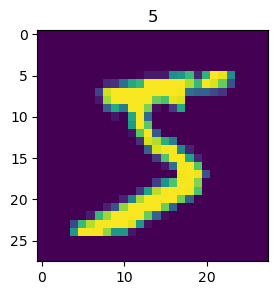

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
plt.title(f"{train_loader.dataset[0][1]}")
plt.imshow(train_loader.dataset[0][0][0])
plt.show()

In [3]:
# model accuracy check
def accuracy(output, target):
    return sum([torch.argmax(o) == t for o, t in zip(output, target)]), len(target)

## Network 1
Simple network with 3 fully connected layers. Sigmoid activation function. Cross Entropy Loss function.

In [4]:
eta = 0.3
epochs = 10

net1 = network.Network1()
print(net1)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net1.parameters(), lr=eta)
net1.zero_grad()

val_accs = []
val_loss = []
train_accs = []
train_loss = []

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    total_loss = 0.
    total_acc = (0, 0)
    
    for i, (X, y) in enumerate(train_loader):
        net1.train() # training mode
        
        output = net1(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_acc = tuple(a + b for a, b in zip(total_acc, accuracy(output, y)))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0: # for every 100th batch
            net1.eval() # evaluation mode
            with torch.no_grad():
                total_val_loss = 0.
                val_acc = (0, 0)
                for j, (val_X, val_y) in enumerate(validation_loader):
                    # evaluation loss and accuracy check
                    output = net1(val_X)
                    val_acc = tuple(a + b for a, b in zip(val_acc, accuracy(output, val_y)))
                    total_val_loss += criterion(output, val_y).item()
                print(f" evaluation accuracy: {100 * val_acc[0] / val_acc[1]}")
                val_accs.append(val_acc)
                val_loss.append(total_val_loss / len(validation_loader))
    
    print(f" training accuracy: {100 * total_acc[0] / total_acc[1]}")
    train_accs.append(total_acc)
    train_loss.append(total_loss / len(train_loader))

Network1(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
epoch 0
 evaluation accuracy: 9.779999732971191
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 evaluation accuracy: 11.420000076293945
 training accuracy: 12.229999542236328
epoch 1
 evaluation accuracy: 15.079999923706055
 evaluation accuracy: 20.540000915527344
 evaluation accuracy: 37.459999084472656
 evaluation accuracy: 43.2400016784668
 evaluation accuracy: 54.0
 evaluation accuracy: 53.91999816894531
 training accuracy: 44.45500183105469
epoch 2
 evaluation accuracy: 61.7400016784668
 evaluation accuracy: 58.119998931884766
 evaluation accuracy: 59.279998779296875
 evaluation accuracy: 58.439998626708984
 evaluation accuracy: 58.47999954223633
 evaluation accuracy: 58.8

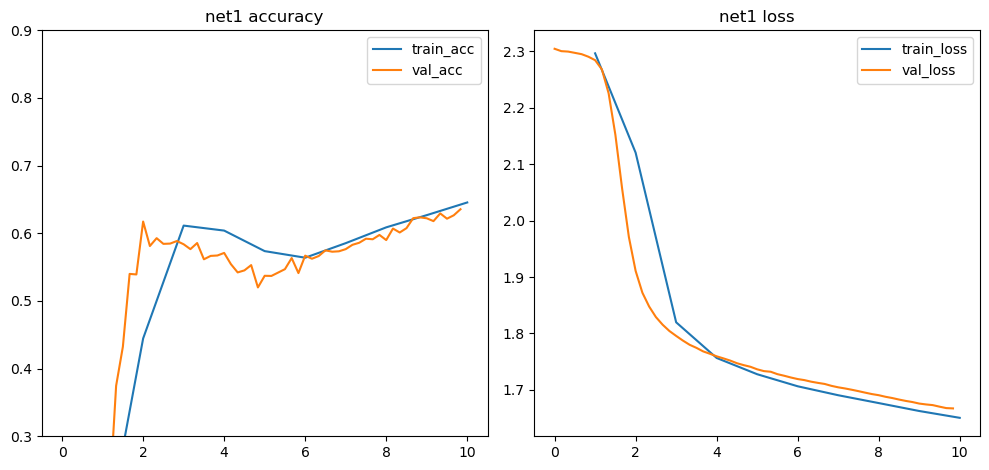

final loss: train 1.6505205357074737 v eval 1.6672040068387985
final acc: train 0.6455833315849304 v eval 0.6355999708175659


In [5]:
fig, ax = plt.subplots(1, 2)
eval_per_epoch = 6

ax[0].plot(range(1, epochs+1), [train_acc[0] / train_acc[1] for train_acc in train_accs], label='train_acc')
ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [val_acc[0] / val_acc[1] for val_acc in val_accs], label='val_acc')
ax[0].set_ylim(0.3, .9)
ax[0].set_title('net1 accuracy')
ax[0].legend()

ax[1].plot(range(1, epochs+1), train_loss, label='train_loss')
ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], val_loss, label='val_loss')
ax[1].set_title('net1 loss')
ax[1].legend()

fig.set_figwidth(10)

plt.tight_layout()
plt.show()

final_acc = (train_accs[-1], val_accs[-1])
final_loss = (train_loss[-1], val_loss[-1])

print(f"final loss: train {final_loss[0]} v eval {final_loss[1]}")
print(f"final acc: train {final_acc[0][0] / final_acc[0][1]} v eval {final_acc[1][0] / final_acc[1][1]}")

Terrible results, even if its only 10 epochs. Actually loses accuracy at a certain point?

## Network 2
Network 1, but with ReLU activation instead of sigmoid.

In [6]:
eta = 0.3
epochs = 10

# Create a SummaryWriter instance
writer = SummaryWriter()

net2 = network.Network2()
print(net2)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net2.parameters(), lr=eta)
net2.zero_grad()

val_accs = []
val_loss = []
train_accs = []
train_loss = []

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    total_loss = 0.
    total_acc = (0, 0)
    
    for i, (X, y) in enumerate(train_loader):
        net2.train() # training mode
        
        output = net2(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_acc = tuple(a + b for a, b in zip(total_acc, accuracy(output, y)))
        
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0: # for every 100th batch
            net2.eval() # evaluation mode
            with torch.no_grad():
                total_val_loss = 0.
                val_acc = (0, 0)
                for j, (val_X, val_y) in enumerate(validation_loader):
                    # evaluation loss and accuracy check
                    output = net2(val_X)
                    val_acc = tuple(a + b for a, b in zip(val_acc, accuracy(output, val_y)))
                    total_val_loss += criterion(output, val_y).item()
                print(f" evaluation accuracy: {100 * val_acc[0] / val_acc[1]}")
                val_accs.append(val_acc)
                val_loss.append(total_val_loss / len(validation_loader))
                
        # Log scalar values
        writer.add_scalar('Net2 Train Loss', total_loss.item(), epoch)
        writer.add_scalar('Net2 Train Acc', total_acc, epoch)
    
    print(f" training accuracy: {100 * total_acc[0] / total_acc[1]}")
    train_accs.append(total_acc)
    train_loss.append(total_loss / len(train_loader))

Network2(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
epoch 0
 evaluation accuracy: 11.34000015258789
 evaluation accuracy: 40.060001373291016
 evaluation accuracy: 42.58000183105469
 evaluation accuracy: 44.08000183105469
 evaluation accuracy: 44.939998626708984
 evaluation accuracy: 45.15999984741211
 training accuracy: 42.573333740234375
epoch 1
 evaluation accuracy: 45.34000015258789
 evaluation accuracy: 45.84000015258789
 evaluation accuracy: 46.13999938964844
 evaluation accuracy: 46.34000015258789
 evaluation accuracy: 46.5
 evaluation accuracy: 46.34000015258789
 training accuracy: 47.314998626708984
epoch 2
 evaluation accuracy: 46.880001068115234
 evaluation accuracy: 46.34000015258789
 evaluation accuracy: 46.040000915527344
 evaluation accuracy: 46.34000015258789
 evaluation accuracy: 46.84000015258789
 evaluation accuracy: 46.90000

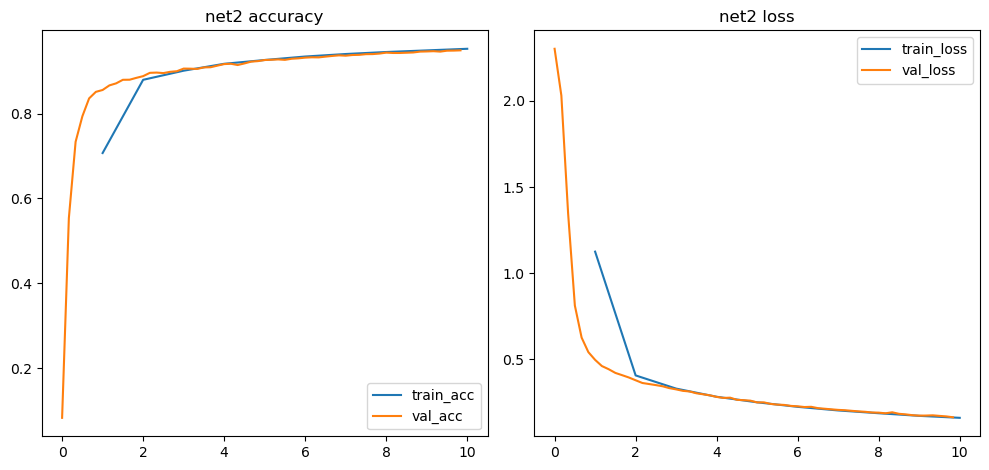

final loss: train 0.1616714242659509 v eval 0.1647713807724248
final acc: train 0.9526666402816772 v eval 0.9490000009536743


In [12]:
fig, ax = plt.subplots(1, 2)
eval_per_epoch = 6

ax[0].plot(range(1, epochs+1), [train_acc[0] / train_acc[1] for train_acc in train_accs], label='train_acc')
ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [val_acc[0] / val_acc[1] for val_acc in val_accs], label='val_acc')
# ax[0].set_ylim(0.8, 1.0)
ax[0].set_title('net2 accuracy')
ax[0].legend()

ax[1].plot(range(1, epochs+1), train_loss, label='train_loss')
ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], val_loss, label='val_loss')
ax[1].set_title('net2 loss')
ax[1].legend()

fig.set_figwidth(10)

plt.tight_layout()
plt.show()

final_acc = (train_accs[-1], val_accs[-1])
final_loss = (train_loss[-1], val_loss[-1])

print(f"final loss: train {final_loss[0]} v eval {final_loss[1]}")
print(f"final acc: train {final_acc[0][0] / final_acc[0][1]} v eval {final_acc[1][0] / final_acc[1][1]}")

Better accuracy, though a fair amount of overfitting going on.

## Network 3
1 Convolutional layer, 2 fully connected layers.

In [8]:
eta = 0.01
epochs = 10
l2_lambda = 0.01
dropout = 0.2

net3 = network.Network3(dropout=dropout)
print(net3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net3.parameters(), lr=eta)
net3.zero_grad()

val_accs = []
val_loss = []
train_accs = []
train_loss = []

layers_to_regularize = [net3.conv, net3.fc1]

for epoch in range(epochs):
    print(f"epoch {epoch}")
    
    total_loss = 0.
    total_acc = (0, 0)
    
    for i, (X, y) in enumerate(train_loader):
        net3.train() # training mode
        
        output = net3(X)
        loss = criterion(output, y)
        total_loss += loss.item()
        total_acc = tuple(a + b for a, b in zip(total_acc, accuracy(output, y))) # total_acc[0] + train_acc[0], total_acc[1] + train_acc[1]
        
        # l2 regularization
        l2_regularization = torch.tensor(0., requires_grad=True)
        for parameter in layers_to_regularize:
            l2_regularization = l2_regularization + torch.norm(parameter.weight, p=2) ** 2
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0: # for every 100th batch
            net3.eval() # evaluation mode
            with torch.no_grad():
                total_val_loss = 0.
                val_acc = (0, 0)
                for j, (val_X, val_y) in enumerate(validation_loader):
                    # evaluation loss and accuracy check
                    output = net3(val_X)
                    val_acc = tuple(a + b for a, b in zip(val_acc, accuracy(output, val_y)))
                    total_val_loss += criterion(output, val_y).item()
                print(f" evaluation accuracy: {100 * val_acc[0] / val_acc[1]}")
                val_accs.append(val_acc)
                val_loss.append(total_val_loss / len(validation_loader))
    
    print(f" training accuracy: {100 * total_acc[0] / total_acc[1]}")
    train_accs.append(total_acc)
    train_loss.append(total_loss / len(train_loader))

Network3(
  (conv): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2880, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
epoch 0
 evaluation accuracy: 8.319999694824219
 evaluation accuracy: 55.380001068115234
 evaluation accuracy: 73.36000061035156
 evaluation accuracy: 79.36000061035156
 evaluation accuracy: 83.58000183105469
 evaluation accuracy: 85.12000274658203
 training accuracy: 70.70166778564453
epoch 1
 evaluation accuracy: 85.55999755859375
 evaluation accuracy: 86.63999938964844
 evaluation accuracy: 87.12000274658203
 evaluation accuracy: 87.95999908447266
 evaluation accuracy: 87.9800033569336
 evaluation accuracy: 88.41999816894531
 training accuracy: 87.9566650390625
epoch 2
 evaluation accuracy: 88.81999969482422
 evaluation accuracy: 89.5999984741211
 evaluation accuracy: 89.66000366210938
 evaluation accuracy: 89.54000091552734
 evaluation accuracy: 89

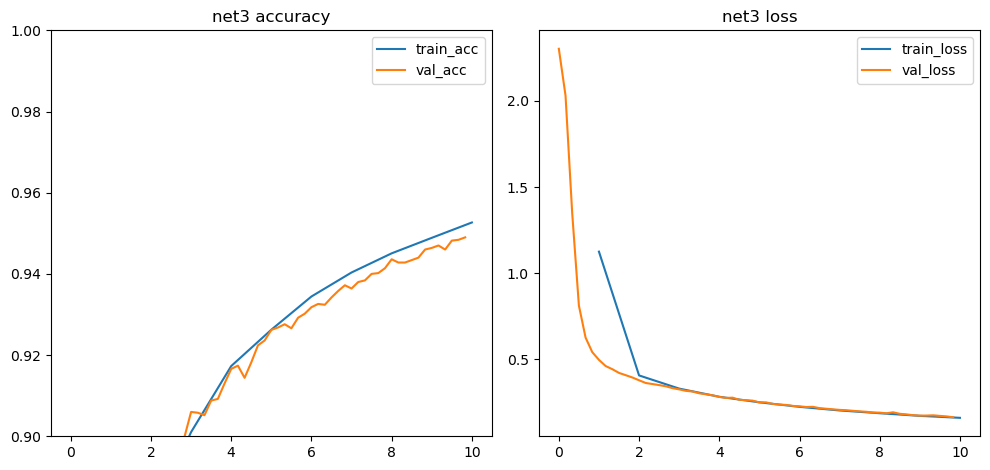

final loss: train 1.1253265420595804 v eval 0.40756538552542526
final acc: train 0.9526666402816772 v eval 0.9490000009536743


In [11]:
fig, ax = plt.subplots(1, 2)
eval_per_epoch = 6

ax[0].plot(range(1, epochs+1), [train_acc[0] / train_acc[1] for train_acc in train_accs], label='train_acc')
ax[0].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], [val_acc[0] / val_acc[1] for val_acc in val_accs], label='val_acc')
ax[0].set_ylim(0.9, 1.)
ax[0].set_title('net3 accuracy')
ax[0].legend()

ax[1].plot(range(1, epochs+1), train_loss, label='train_loss')
ax[1].plot([i/eval_per_epoch for i in range(eval_per_epoch * epochs)], val_loss, label='val_loss')
# ax[1].set_ylim(0.0, 1.)
ax[1].set_title('net3 loss')

fig.set_figwidth(10)

plt.tight_layout()
plt.legend()
plt.show()

final_acc = (train_accs[-1], val_accs[-1])
final_loss = (train_loss[-1], val_loss[-1])

print(f"final loss: train {train_loss[0]} v eval {train_loss[1]}")
print(f"final acc: train {final_acc[0][0] / final_acc[0][1]} v eval {final_acc[1][0] / final_acc[1][1]}")

Minimal overfitting.

Vanishing gradient detection?